# Lab 2: Fine-tuning BERT To Perform Causal Common Sense Reasoning

## Due: May 26, 2024

Welcome to the Assignment 2 of our course on Natural Language Processing. Similar to Lab 2, we will again be working on a common sense reasoning task and fine-tuning BERT to solve the same. Specifically, we will be looking at [Choice Of Plausible Alternatives (COPA) dataset](https://people.ict.usc.edu/~gordon/copa.html) which was created to access common-sense causal reasoning of NLP models. This assignment should flow naturally from Lab 2, and we shall see with minimal changes we will be able to adapt what we learned for SocialIQA task on COPA.

Suggested Reading:
- [Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding*](https://arxiv.org/pdf/1810.04805.pdf)
- [Maarten Sap, Hannah Rashkin, Derek Chen, Ronan Le Bras, and Yejin Choi. 2019. Social IQa: Commonsense Reasoning about Social Interactions. In Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), pages 4463–4473, Hong Kong, China. Association for Computational Linguistics.] (https://arxiv.org/pdf/1810.04805.pdf)

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# copa_data_dir = "gdrive/MyDrive/PlakshaNLP2024/Assignment2/data/copa/"

In [5]:
copa_data_dir = r"E:\Shiny_Laptop_Till_july(Prob.)\Github\PlakshaTLF24-NLP\Assignment02\copa"

In [6]:
# Install required libraries
# If using Colab, DO NOT INSTALL ANYTHING!
# !pip install numpy
# !pip install pandas
# !pip install torch
# !pip install tqdm
# !pip install matplotlib
# !pip install transformers
# !pip install scikit-learn
# !pip install tqdm

In [7]:
# We start by importing libraries that we will be making use of in the assignment.
import os
from functools import partial
import json
import xml.etree.ElementTree as ET
from pprint import pprint
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import copy
from tqdm.notebook import tqdm

from transformers.utils import logging
logging.set_verbosity(40) # to avoid warnings from transformers

## COPA Dataset

We start by discussing the dataset that we will making use of in today's Assignment. As described above, the COPA evaluation provides researchers with a tool for assessing progress in open-domain commonsense causal reasoning. COPA consists of 1000 questions, split equally into development and test sets of 500 questions each. Each question is composed of a premise and two alternatives, where the task is to select the alternative that more plausibly has a causal relation with the premise. Some examples from the dataset include:

```
Premise: The man broke his toe. What was the CAUSE of this?
Alternative 1: He got a hole in his sock.
Alternative 2: He dropped a hammer on his foot.

Premise: I tipped the bottle. What happened as a RESULT?
Alternative 1: The liquid in the bottle froze.
Alternative 2: The liquid in the bottle poured out.

Premise: I knocked on my neighbor's door. What happened as a RESULT?
Alternative 1: My neighbor invited me in.
Alternative 2: My neighbor left his house.
```

Below we load the dataset in memory. Since there is no seperate training set, we use dev set for training the model and evaluate on test set.

In [8]:
def parse_copa_dataset(split="test"):
    tree = ET.parse(f"{copa_data_dir}/copa-{split}.xml")
    root = tree.getroot()
    items = root.findall("item")

    data = []
    labels = []
    for item in items:
        data.append(
            {
                "question": item.get("asks-for"),
                "premise": item.find("p").text,
                "choice1": item.find("a1").text,
                "choice2": item.find("a2").text,
            }
        )
        labels.append(int(item.get("most-plausible-alternative")) - 1)

    return data, labels

train_data, train_labels = parse_copa_dataset("dev")
test_data, test_labels = parse_copa_dataset("test")

print(f"Number of Training Examples: {len(train_data)}")
print(f"Number of Test Examples: {len(test_data)}")

Number of Training Examples: 500
Number of Test Examples: 500


c:\Users\shish\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<AxesSubplot: ylabel='count'>

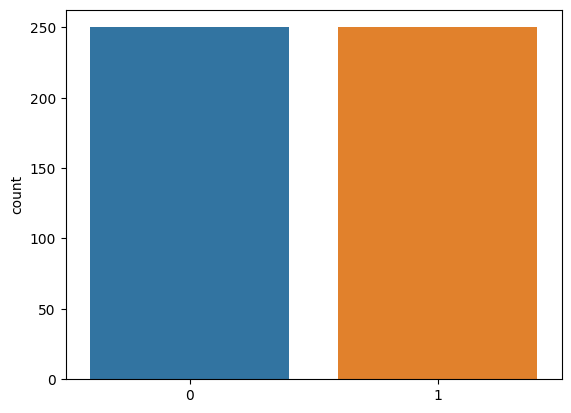

In [9]:
sns.countplot(x = train_labels)

In [10]:
# View a sample of the dataset
print("Example from dataset")
pprint(train_data[100], sort_dicts=False, indent=4)
print(f"Label: {train_labels[100]}")

Example from dataset
{   'question': 'effect',
    'premise': 'The teacher took roll.',
    'choice1': 'She identified the students that were absent.',
    'choice2': 'She gave her students a pop quiz.'}
Label: 0


As you can see, the dataset is pretty much very similar as SocialIQA, with the main difference being that we have two answer choices instead of three. Hence, we just need to concatenate choice1 and choice2, seperately with premise and question this time.

In [11]:
# Import the BertTokenizer from the library
from transformers import BertTokenizer

# Load a pre-trained BERT Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

example = train_data[100]
premise = example["premise"]
question = example["question"]
choice1 = example["choice1"]
choice2 = example["choice2"]

pqc1 = premise + bert_tokenizer.sep_token + question + bert_tokenizer.sep_token + choice1
pqc2 = premise + bert_tokenizer.sep_token + question + bert_tokenizer.sep_token + choice2

print(pqc1)
print(pqc2)

tokenized_pqc1 = bert_tokenizer(pqc1)
tokenized_pqc2 = bert_tokenizer(pqc2)


The teacher took roll.[SEP]effect[SEP]She identified the students that were absent.
The teacher took roll.[SEP]effect[SEP]She gave her students a pop quiz.


## Task 1: Setting up Custom Datasets and Dataloaders (4 Marks)

## Task 1.1: Custom Dataset Class (2 Marks)

Similar to Lab 2, you will start by implementing a custom Dataset class for COPA dataset. The only difference will be that `__getitem__` should return tokenized outputs corresponding to the two choices choice1 and choice2, instead of three like in the case of SocialIQA dataset.

In [ ]:
class COPAdata:
    def __init__(self, data, tokenizer):
        """
        Initialize the data with COPA examples and a tokenizer.

        Inputs:
            - data (list): List of COPA examples where each example is a dictionary containing 'sentence', 'choice1', 'choice2', and 'label'.
            - tokenizer: Tokenizer object (e.g., from Hugging Face's transformers library).
        """
        self.data = data
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        """
        Returns the training example corresponding to COPA example present at the `idx` position in the data.

        Inputs:
            - idx (int): Index corresponding to the data example to be returned

        Returns:
            - tokenized_input_dict (dict(str, dict)): A dictionary corresponding to tokenizer outputs for the two resulting sequences due to each answer choice as described above
            - label (int): Answer label for the corresponding sentence. 0 for first answer choice and 1 for second answer choice.

        Example Output:
            - tokenized_input_dict: {
                "choice1": {'input_ids': [101, 5207, 1005, 1055, 3899, 21392, 2094, 2006, 1996, 6411, 2027, 2020, 4855, 1998, 5207, 3718, 1996, 19255, 2004, 2574, 2004, 2825, 1012, 102, 2129, 2052, 5207, 2514, 5728, 1029, 102, 4855, 1037, 6411, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
                "choice2": {'input_ids': [101, 5207, 1005, 1055, 3899, 21392, 2094, 2006, 1996, 6411, 2027, 2020, 4855, 1998, 5207, 3718, 1996, 19255, 2004, 2574, 2004, 2825, 1012, 102, 2129, 2052, 5207, 2514, 5728, 1029, 102, 17733, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
            }
            - label: 0
        """
        example = self.data[idx]
        sentence = example['sentence']
        choice1 = example['choice1']
        choice2 = example['choice2']
        label = example['label']

        # Tokenize the sentence with each choice
        tokenized_input_dict = {
            "choice1": self.tokenizer.encode_plus(
                sentence + " " + choice1,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            ),
            "choice2": self.tokenizer.encode_plus(
                sentence + " " + choice2,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            ),
        }

        # Convert tensors to lists for compatibility with the expected output format
        tokenized_input_dict = {key: {k: v.squeeze().tolist() for k, v in value.items()} for key, value in tokenized_input_dict.items()}

        return tokenized_input_dict, label

    def __len__(self):
        return len(self.data)


In [53]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

class COPABertDataset(Dataset):

    def __init__(self, data, labels, bert_variant = "bert-base-uncased"):
        """
        Constructor for the `COPABertDataset` class. Stores the `data` and `labels` which can then be used by
        other methods. Also initializes the tokenizer

        Inputs:
            - data (list) : A list COPA dataset examples
            - labels (list): A list of answer labels corresponding to each example
            - bert_variant (str): A string indicating the variant of BERT to be used.
        """
        self.data = data
        self.labels = labels
        self.tokenizer = AutoTokenizer.from_pretrained(bert_variant)

        # YOUR CODE HERE
        # raise NotImplementedError()

    def __len__(self):
        """
        Returns the length of the dataset
        """
        length = len(self.data)

        # YOUR CODE HERE
        # raise NotImplementedError()

        return length

    def __getitem__(self, idx):
        """
        Returns the training example corresponding to COPA example present at the `idx` position in the dataset

        Inputs:
            - idx (int): Index corresponding to the dataset example to be returned

        Returns:
            - tokenized_input_dict (dict(str, dict)): A dictionary corresponding to tokenizer outputs for the two resulting sequences due to each answer choices as described above
            - label (int): Answer label for the corresponding sentence. 0 for first answer choice and 1 for second answer choice.

        Example Output:
            - tokenized_input_dict: {
                "choice1": {'input_ids': [101, 5207, 1005, 1055, 3899, 21392, 2094, 2006, 1996, 6411, 2027, 2020, 4855, 1998, 5207, 3718, 1996, 19255, 2004, 2574, 2004, 2825, 1012, 102, 2129, 2052, 5207, 2514, 5728, 1029, 102, 4855, 1037, 6411, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
                "choice2": {'input_ids': [101, 5207, 1005, 1055, 3899, 21392, 2094, 2006, 1996, 6411, 2027, 2020, 4855, 1998, 5207, 3718, 1996, 19255, 2004, 2574, 2004, 2825, 1012, 102, 2129, 2052, 5207, 2514, 5728, 1029, 102, 17733, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
            }
            - label: 0

        """
        
        example = self.data[idx]
        label = self.labels[idx]

        premise = example['premise']
        choice1 = example['choice1']
        choice2 = example['choice2']

        encoding_choice1 = self.tokenizer(
            premise,
            choice1,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        encoding_choice2 = self.tokenizer(
            premise,
            choice2,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )

        tokenized_input_dict = {
            "choice1": {key: val.squeeze(0) for key, val in encoding_choice1.items()},
            "choice2": {key: val.squeeze(0) for key, val in encoding_choice2.items()},
        }

        # YOUR CODE HERE
        # raise NotImplementedError()

        return tokenized_input_dict, label

In [57]:
print("Running Sample Test Cases")

sample_dataset = COPABertDataset(train_data[:2], train_labels[:2], bert_variant="bert-base-uncased")

print(f"Sample Test Case 1: Checking if `__len__` is implemented correctly")
dataset_len= len(sample_dataset)
expected_len = 2
print(f"Dataset Length: {dataset_len}")
print(f"Expected Length: {expected_len}")
assert len(sample_dataset) == expected_len
print("Sample Test Case Passed!")
print("****************************************\n")

print(f"Sample Test Case 2: Checking if `__getitem__` is implemented correctly for `idx= 0`")
sample_idx = 1
tokenized_input_dict, label = sample_dataset.__getitem__(sample_idx)
expected_tokenized_input_dict = {'choice1': {'input_ids': [101, 2026, 2303, 3459, 1037, 5192, 2058, 1996, 5568, 1012, 102, 3426, 102, 1996, 3103, 2001, 4803, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 'choice2': {'input_ids': [101, 2026, 2303, 3459, 1037, 5192, 2058, 1996, 5568, 1012, 102, 3426, 102, 1996, 5568, 2001, 3013, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}
expected_label = 0
print(f"tokenized_input_dict:\n {tokenized_input_dict}")
print(f"Expected tokenized_input_dict:\n {expected_tokenized_input_dict}")
assert (expected_tokenized_input_dict == tokenized_input_dict)

print(f"label:\n {label}")
print(f"Expected label:\n {expected_label}")
assert expected_label == label

print("Sample Test Case Passed!")
print("****************************************\n")


print(f"Sample Test Case 3: Checking if `__getitem__` is implemented correctly for `idx= 1`")
sample_idx = 0
tokenized_input_dict, label = sample_dataset.__getitem__(sample_idx)
expected_tokenized_input_dict = {'choice1': {'input_ids': [101, 1996, 2450, 25775, 2014, 2767, 1005, 1055, 3697, 5248, 1012, 102, 3426, 102, 1996, 2450, 2354, 2014, 2767, 2001, 2183, 2083, 1037, 2524, 2051, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 'choice2': {'input_ids': [101, 1996, 2450, 25775, 2014, 2767, 1005, 1055, 3697, 5248, 1012, 102, 3426, 102, 1996, 2450, 2371, 2008, 2014, 2767, 2165, 5056, 1997, 2014, 16056, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}

expected_label = 0
print(f"tokenized_input_dict:\n {tokenized_input_dict}")
print(f"Expected tokenized_input_dict:\n {expected_tokenized_input_dict}")
assert (expected_tokenized_input_dict == tokenized_input_dict)

print(f"label:\n {label}")
print(f"Expected label:\n {expected_label}")
assert expected_label == label

print("Sample Test Case Passed!")
print("****************************************\n")

print(f"Sample Test Case 4: Checking if `__getitem__` is implemented correctly for `idx= 0` for a different bert-variant")
sample_dataset = COPABertDataset(train_data[:2], train_labels[:2], bert_variant="bert-base-cased")
sample_idx = 0
tokenized_input_dict, label = sample_dataset.__getitem__(sample_idx)
expected_tokenized_input_dict = {'choice1': {'input_ids': [101, 1422, 1404, 2641, 170, 6464, 1166, 1103, 5282, 119, 102, 2612, 102, 1109, 3336, 1108, 4703, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 'choice2': {'input_ids': [101, 1422, 1404, 2641, 170, 6464, 1166, 1103, 5282, 119, 102, 2612, 102, 1109, 5282, 1108, 2195, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}}
expected_label = 0
print(f"tokenized_input_dict:\n {tokenized_input_dict}")
print(f"Expected tokenized_input_dict:\n {expected_tokenized_input_dict}")
assert (expected_tokenized_input_dict == tokenized_input_dict)

print(f"label:\n {label}")
print(f"Expected label:\n {expected_label}")
assert expected_label == label

print("Sample Test Case Passed!")
print("****************************************\n")

Running Sample Test Cases
Sample Test Case 1: Checking if `__len__` is implemented correctly
Dataset Length: 2
Expected Length: 2
Sample Test Case Passed!
****************************************

Sample Test Case 2: Checking if `__getitem__` is implemented correctly for `idx= 0`
tokenized_input_dict:
 {'choice1': {'input_ids': tensor([  101,  1996,  2482,  3631,  2091,  2006,  1996,  3307,  1012,   102,
         1996,  4062,  2170,  1037, 15805,  4744,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    

We can now create Dataset instances for both training and dev datasets

In [58]:


train_dataset = COPABertDataset(train_data, train_labels, bert_variant="bert-base-uncased")
test_dataset = COPABertDataset(test_data, test_labels, bert_variant="bert-base-uncased")

## Task 1.2: Custom `collate_fn` Class (2 Marks)

Similar to Lab 2, you will now implement a custom `colate_fn` for the `COPABertDataset` class. Remember, a `colate_fn` informs a dataloader on how to construct batches from a list of sequences in a batch. Implement `collate_fn` that takes a batch which is a list of tuples of the form `(tokenized_input_dict, label)` and constructs the batches of following:
- `input_ids_dict`: A dictionary containing batch of `input_ids` tensors corresponding to both choice1 and choice2. You will need to do padding here,
- `attn_mask_dict`: A dictionary containing batch of `attention_mask` tensors corresponding to both choice1 and choice2. You will need to do padding here,
- `labels`: A tensor of shape [batch_size, ] containing the labels for each example in the batch

In [ ]:
def collate_fn(tokenizer, batch):
    """
    Collate function to be used when creating a data loader for the COPA dataset.
    :param tokenizer: The tokenizer to be used to tokenize the inputs.
    :param batch: A list of tuples of the form (tokenized_input_dict, label)
    :return:
        - A tuple of the form (input_ids_dict, attn_mask_dict, labels) as described above
    """

    colated_batch = (None, None, None)

    # YOUR CODE HERE
    # raise NotImplementedError()

    return colated_batch

In [102]:
import torch
from transformers import AutoTokenizer

def collate_fn(tokenizer, batch,max_length=27):
    """
    Collate function to be used when creating a data loader for the COPA dataset.
    :param tokenizer: The tokenizer to be used to tokenize the inputs.
    :param batch: A list of tuples of the form (tokenized_input_dict, label)
    :return:
        - A tuple of the form (input_ids_dict, attn_mask_dict, labels) as described above
    """

    # Initialize lists to hold the batched data
    tokenized_inputs_choice1 = []
    tokenized_inputs_choice2 = []
    labels = []

    # Iterate over the batch to accumulate tokenized inputs and labels
    for tokenized_input_dict, label in batch:
        tokenized_inputs_choice1.append(tokenized_input_dict["choice1"])
        tokenized_inputs_choice2.append(tokenized_input_dict["choice2"])
        labels.append(label)

    # Pad the inputs for choice1 and choice2
    # tokenized_inputs_choice1 = tokenizer.pad(tokenized_inputs_choice1, padding=True, return_tensors="pt")
    # tokenized_inputs_choice2 = tokenizer.pad(tokenized_inputs_choice2, padding=True, return_tensors="pt")
    tokenized_inputs_choice1 = tokenizer.pad(tokenized_inputs_choice1, padding='max_length', max_length=max_length, return_tensors="pt")
    tokenized_inputs_choice2 = tokenizer.pad(tokenized_inputs_choice2, padding='max_length', max_length=max_length, return_tensors="pt")

    # Extract input_ids and attention_mask
    input_ids_dict = {
        "choice1": tokenized_inputs_choice1["input_ids"],
        "choice2": tokenized_inputs_choice2["input_ids"]
    }
    attn_mask_dict = {
        "choice1": tokenized_inputs_choice1["attention_mask"],
        "choice2": tokenized_inputs_choice2["attention_mask"]
    }

    # Convert labels list to a tensor
    labels = torch.tensor(labels, dtype=torch.long)

    # Construct the tuple
    colated_batch = (input_ids_dict, attn_mask_dict, labels)

    return colated_batch

In [103]:
print("Running Sample Test Cases")

sample_dataset = COPABertDataset(train_data[:2], train_labels[:2], bert_variant="bert-base-uncased")
batch = [sample_dataset.__getitem__(0), sample_dataset.__getitem__(1)]


print(f"Sample Test Case 1: Checking if the return output of `collate_fn` is of the correct type")
colated_batch = collate_fn(bert_tokenizer, batch)
print(f"Output type: {type(colated_batch)}")
assert (type(colated_batch) == tuple)
print(f"Tuple Length: {len(colated_batch)}")
assert (len(colated_batch) == 3)
print(f"Tuple 0th element type: {type(colated_batch[0])}")
assert (type(colated_batch[0]) == dict)
print(f"Tuple 1st element type: {type(colated_batch[1])}")
assert (type(colated_batch[1]) == dict)
print(f"Tuple 2nd element type: {type(colated_batch[2])}")
assert (type(colated_batch[2]) == torch.Tensor)
print("Sample Test Case Passed!")
print("****************************************\n")

print(f"Sample Test Case 2: Checking if the return output of `collate_fn` is of the correct shape")
print(f"Tuple 0th element shape for choice1: {colated_batch[0]['choice1'].shape}")
assert (colated_batch[0]['choice1'].shape == torch.Size([2,27]))
print(f"Tuple 0th element shape for choice2: {colated_batch[0]['choice2'].shape}")
assert (colated_batch[0]['choice2'].shape == torch.Size([2,27]))

print(f"Tuple 1st element shape for choice1: {colated_batch[1]['choice1'].shape}")
assert (colated_batch[1]['choice1'].shape == torch.Size([2,27]))
print(f"Tuple 1st element shape for choice2: {colated_batch[1]['choice2'].shape}")
assert (colated_batch[1]['choice2'].shape == torch.Size([2,27]))

print(f"Tuple 2nd element shape: {colated_batch[2].shape}")
assert (colated_batch[2].shape == torch.Size([2]))

print("Sample Test Case Passed!")
print("****************************************\n")

print(f"Sample Test Case 3: Checking if the return output of `collate_fn` is of the correct values")
tup0_choice1_expected = torch.tensor([[  101,  2026,  2303,  3459,  1037,  5192,  2058,  1996,  5568,  1012,
           102,  3426,   102,  1996,  3103,  2001,  4803,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  1996,  2450, 25775,  2014, 2767,  1005,  1055,  3697,  5248,
          1012,   102,  3426,   102,  1996,  2450,  2354,  2014, 2767,  2001,
          2183,  2083,  1037,  2524,  2051,  1012,   102]])
print(f"Tuple 0th element predicted values for choice1: {colated_batch[0]['choice1']}")
print(f"Tuple 0th element expected values for choice1: {tup0_choice1_expected}")
assert (torch.allclose(colated_batch[0]['choice1'], tup0_choice1_expected))

Running Sample Test Cases
Sample Test Case 1: Checking if the return output of `collate_fn` is of the correct type
Output type: <class 'tuple'>
Tuple Length: 3
Tuple 0th element type: <class 'dict'>
Tuple 1st element type: <class 'dict'>
Tuple 2nd element type: <class 'torch.Tensor'>
Sample Test Case Passed!
****************************************

Sample Test Case 2: Checking if the return output of `collate_fn` is of the correct shape
Tuple 0th element shape for choice1: torch.Size([2, 512])


AssertionError: 

Now that we have defined the collate_fn, lets create the dataloaders. It is common to use smaller batch size while fine-tuning these big models, as they occupy quite a lot of memory.

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=partial(collate_fn, train_dataset.tokenizer))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=partial(collate_fn, test_dataset.tokenizer))

In [ ]:
batch_input_ids, batch_attn_mask, batch_labels = next(iter(train_loader))
print(f"batch_input_ids:\n {batch_input_ids}")
print(f"batch_attn_mask:\n {batch_attn_mask}")
print(f"batch_labels:\n {batch_labels}")

## Task 2: Implementing and Training BERT-based Multiple Choice Classifier (6 Marks)


In [ ]:
# Import BertModel from the library
from transformers import BertModel

# Create an instance of pretrained BERT
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model

### Task 2.1: Implementing BERT-based Classifier for Multiple Choice Classification (2 Marks)

We will be using trhe same exact architecture as SocialIQA dataset here as well i.e. we have the BERT model as the backbone, using which we obtain the contextualized representation of the [premise, question, answer] sequence. We then use the \[CLS\] token's embedding as the sequence representation and feed it to a 2 layer MLP (Linear(768, 768) -> ReLU -> Linear(768, 1)) that scores the answer.

![architecture](https://i.ibb.co/hVmS9Qx/siqa-bert-arch-excalli.png)

The only change this time will be that to predict the correct answer, we need to score each of the two choices each instead of the three answers. Afterwards, like last time we ormalize the scores for the choices by applying softmax, that gives us the probability of each option being the correct answer.


<!-- ![forward pass](https://i.ibb.co/r3SrLHY/siqa-bert-forward-excalli.png) -->

Implement the architecture and forward pass in `BertMultiChoiceClassifierModel` class below:

In [ ]:
class BertMultiChoiceClassifierModel(nn.Module):

    def __init__(self, d_hidden = 768, bert_variant = "bert-base-uncased"):
        """
        Define the architecture of Bert-Based mulit-choice classifier.
        You will mainly need to define 3 components, first a BERT layer
        using `BertModel` from transformers library,
        a two layer MLP layer to map the representation from Bert to the output i.e. (Linear(d_hidden, d_hidden) -> ReLU -> Linear(d_hidden, 1)),
        and a log sftmax layer to map the scores to a probabilities

        Inputs:
            - d_hidden (int): Size of the hidden representations of bert
            - bert_variant (str): BERT variant to use
        """
        super(BertMultiChoiceClassifierModel, self).__init__()
        self.bert_layer = None
        self.mlp_layer = None
        self.log_softmax_layer = None

        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(self, input_ids_dict, attn_mask_dict):
        """
        Forward Passes the inputs through the network and obtains the prediction

        Inputs:
            - input_ids_dict (dict(str,torch.tensor)): A dictionary containing input_ids corresponding to each answer choice. Keys are choice1 and choice2, and value is a torch tensor of shape [batch_size, seq_len]
                                        representing the sequence of token ids
            - attn_mask_dict (dict(str,torch.tensor)): A dictionary containing attention mask corresponding to each answer choice. Keys are choice1 and choice2, and value is a torch tensor of shape [batch_size, seq_len]

        Returns:
          - output (torch.tensor): A torch tensor of shape [batch_size,] obtained after passing the input to the network

        """
        output = None

        # YOUR CODE HERE
        raise NotImplementedError()

        return output

In [ ]:
print(f"Running Sample Test Cases!")
torch.manual_seed(42)
model = BertMultiChoiceClassifierModel()

print("Sample Test Case 1")
batch_input_ids, batch_attn_mask, batch_labels = next(iter(train_loader))
bert_out = model(batch_input_ids, batch_attn_mask).detach().numpy()
expected_bert_out = np.array([[-0.69547975, -0.6908201 ],
                            [-0.6995947,  -0.68674093],
                            [-0.68830335, -0.6980145 ],
                            [-0.6899294,  -0.6963753 ],
                            [-0.6987722,  -0.68755364],
                            [-0.7084117,  -0.6781122 ],
                            [-0.6960533,  -0.6902495 ],
                            [-0.6748525,  -0.71178275],
                            [-0.6868652,  -0.699469  ],
                            [-0.68641526, -0.6999247 ],
                            [-0.6998995,  -0.68644005],
                            [-0.70553845, -0.6809075 ],
                            [-0.7043667,  -0.6820522 ],
                            [-0.6675567,  -0.7194098 ],
                            [-0.700077,   -0.6862651 ],
                            [-0.72046393, -0.6665568 ]])
print(f"Model Output: {bert_out}")
print(f"Expected Output: {expected_bert_out}")

assert bert_out.shape == expected_bert_out.shape
assert np.allclose(bert_out, expected_bert_out, 1e-4)
print("Test Case Passed! :)")
print("******************************\n")

print("Sample Test Case 2")
batch_input_ids, batch_attn_mask, batch_labels = next(iter(test_loader))
bert_out = model(batch_input_ids, batch_attn_mask).detach().numpy()
expected_bert_out = np.array([[-0.6993066,  -0.6870254 ],
                            [-0.7057758,  -0.68067616],
                            [-0.670608,   -0.71620613],
                            [-0.6946109,  -0.69168556],
                            [-0.6930771,  -0.69321734],
                            [-0.6869541,  -0.6993789 ],
                            [-0.68364906, -0.7027364 ],
                            [-0.68642354, -0.6999164 ],
                            [-0.6944856,  -0.69181055],
                            [-0.6879125,  -0.6984094 ],
                            [-0.7094514,  -0.67710465],
                            [-0.68425775, -0.7021164 ],
                            [-0.6869471,  -0.6993859 ],
                            [-0.69160426, -0.6946925 ],
                            [-0.68354183, -0.7028456 ],
                            [-0.69150895, -0.69478804]])
print(f"Model Output: {bert_out}")
print(f"Expected Output: {expected_bert_out}")

assert bert_out.shape == expected_bert_out.shape
assert np.allclose(bert_out, expected_bert_out, 1e-4)
print("Test Case Passed! :)")
print("******************************\n")

### Task 2.2: Training and Evaluating the Model (3 Marks)

Now that we have implemented the custom Dataset and a BERT based classifier model, we can start training and evaluating the model as in Lab 2. You will need to implement the `train` and `evaluate` functions below.

In [ ]:
def evaluate(model, test_dataloader, device = "cpu"):
    """
    Evaluates `model` on test dataset

    Inputs:
        - model (BertMultiChoiceClassifierModel): A BERT based multiple choice classification model to be evaluated
        - test_dataloader (torch.utils.DataLoader): A dataloader defined over the test dataset

    Returns:
        - accuracy (float): Average accuracy over the test dataset
    """

    model.eval()
    model = model.to(device)
    accuracy = 0

    # YOUR CODE HERE
    raise NotImplementedError()
    return accuracy


def train(model, train_dataloader, test_dataloader,
          lr = 1e-5, num_epochs = 3,
          device = "cpu"):
    """
    Runs the training loop. Define the loss function as BCELoss like the last tine
    and optimizer as Adam and traine for `num_epochs` epochs.

    Inputs:
        - model (BertMultiChoiceClassifierModel):  A BERT based multiple choice classification model to be trained
        - train_dataloader (torch.utils.DataLoader): A dataloader defined over the training dataset
        - test_dataloader (torch.utils.DataLoader): A dataloader defined over the test dataset
        - lr (float): The learning rate for the optimizer
        - num_epochs (int): Number of epochs to train the model for.
        - device (str): Device to train the model on. Can be either 'cuda' (for using gpu) or 'cpu'

    Returns:
        - test_accuracy (float): Test accuracy corresponding to the last epoch
        Note that we are not doing model selection here since we do not have access to a validation set for this task.
          It is not a good practice to do model selection on the test set. Hence, we just return the performance we get after training the model
    """
    epoch_loss = 0
    model = model.to(device)
    test_accuracy = None
    # YOUR CODE HERE
    raise NotImplementedError()
    return test_accuracy

In [ ]:
torch.manual_seed(0)
model = BertMultiChoiceClassifierModel()
test_acc = train(model, train_loader, test_loader, num_epochs = 10, lr = 5e-6, device = "cuda")

You should expect about ~65% test accuracy. Note that the model quickly overfits to the dataset in this case, i.e. the training loss reduces dramatically, but there isn't much improvement in the test accuracy after the first epoch. This happens because our training data consists of just 500 examples, which is usually not sufficient for training these large models. Next, we try out a simple strategy to improve the performance drastically.

### Task 2.3: Continued Fine-tuning of BERT trained on SocialIQA Dataset (1 Mark)

In Lab2, we fine-tuned BERT on SocialIQA, which is also a common sense reasoning task and has a much larger training set. Deep learning models exhibhit a remarkable property of transfer learning where we can leverage a model trained on task to transfer it's knowledge for learning a new task much more effectively. The idea is that training on SocialIQA dataset would have endowed our model with some common-sense reasoning capabilities, which we can leverage to learn COPA task as well.

Below, you are needed to load the model that you trained in Lab2 and the train that model instead. You can read about how to load pre-trained models in pytorch [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html). Once you load the model, to train it, just call the `train` function as before.

In [ ]:
model = BertMultiChoiceClassifierModel()
model_path = "../Lab2/models/siqa_bert-base-uncased/model.pt" # Change this to the path of your model trained in Lab2.

# Step 1: Load the pre-trained model weights
# YOUR CODE HERE
raise NotImplementedError()

# Step 2: Train the loaded model on COPA dataset
# YOUR CODE HERE
raise NotImplementedError()

You should expect ~77% accuracy with this, which is quite a large increase over the original 65% accuracy that we obtained by training the model from scratch. This illustrates the effectiveness of transfer-learning for NLP tasks, specially when the two tasks are related as they were in this case. Transfer learning had been the dominant paradigm in NLP since 2018. However, recently we have been witnessing a new paradigm emerge called "Prompting", which has taken the NLP community and in many ways the whole world by a storm. In the next lab and assignments, we will learn more about this new paradigm.